<a href="https://colab.research.google.com/github/wavemx/covid19/blob/master/USStateAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.special import expit

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

from pathlib import Path
import datetime as datetime
import operator
import sys
import warnings
import math


In [0]:
# Load data, drop unneeded lat/long columns and group by country/region
def loadAndGroup(fileName, groupBy="Province_State", dropColumns=["UID","iso2","iso3","code3","FIPS","Admin2","Country_Region","Lat","Long_","Combined_Key"], extraDrop=[]):   #,"Population"
    df=pd.read_csv(fileName)
    for dc in dropColumns+extraDrop:
        df.drop(dc, axis=1, inplace=True)
    df=df.groupby(groupBy).sum()
    for dc in range(30):
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =np.array(range(len(days)))
    values=df1.to_numpy()
    return days, daynr, values

def loadAndGroupPop(fileName, groupBy="Province_State", focusColumn="Population"):
    df=pd.read_csv(fileName)
    df=df[[groupBy,focusColumn]]
    df=df.groupby(groupBy).sum()
    return df

totalLabel="US"

Path('plotsUS/').mkdir(exist_ok=True)

In [0]:
# Load data and calculate derived values: totals, absolute daily deltas, percentage daily deltas
useLiveGit    =True
if useLiveGit:
    confd     =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
else:
    confd     =loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
confd         =confd.append(confd.sum(axis=0).rename(totalLabel))
confdDelta    =confd.diff(axis=1).replace(np.nan, 0)
confdDeltaPerc=(confdDelta/confd.shift(periods=1, axis=1)).replace(np.nan, 0).replace(np.inf, 0)
today         =confd.columns[-1]

if useLiveGit:
    deaths     =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv', extraDrop=["Population"])
else:
    deaths     =loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
deaths         =deaths.append(deaths.sum(axis=0).rename(totalLabel))
deathsDelta    =deaths.diff(axis=1).replace(np.nan, 0)
deathsDeltaPerc=(deathsDelta/deaths.shift(periods=1, axis=1)).replace(np.nan, 0).replace(np.inf, 0)



population=loadAndGroupPop('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
totalPopulation=population.sum(axis=0).rename(totalLabel)
population=population.append(totalPopulation)

# Calculate daily increment of a data series
def diff(ys):
    res=[0]
    cur=ys[0]
    for y in ys[1:]:
        res.append(y-cur)
        cur=y
    return res


In [0]:
# Format to three significant digits
def s3(x):
    return np.around(x,decimals=3)

In [0]:
# Formatting for figures ranging in single digits, thousands, millions and billions
def FormatReadable(x, plus=False):
    if math.isnan(x):
        return "NaN"
    if x<0:
        return "-"+FormatReadable(-x, plus=False)
    if plus:
        return "+"+FormatReadable(x, plus=False)
    if x==0:
        return "0"
    formats=[ (10000000000, 1000000000,"%.0fb"), (1000000000,1000000000, "%.1fb"), (10000000, 1000000, "%.0fm"), 
             (1000000, 1000000, "%.1fm"), (10000,1000,"%.0fk"), (1000,1000,"%.1fk"), (10,1, "%d"), (0,1, "%.1f") ]
    for threshold, divider, formatString in formats:
        if x>=threshold:
            return formatString % (x/divider)

In [0]:
def percentReadable(x):
    return "%.1f%%" % (x*100) #changed from .1% to .01%
        
@plticker.FuncFormatter
def hrFormatter(x, pos):
    return FormatReadable(x)

# Label last datapoint of a series
def labelLast(ax, x, y, c='tab:red', ha='left', va='center', weight='normal', formatter=FormatReadable):
    if y[-1]>0:
        ax.annotate(formatter(y[-1]), (x[-1],y[-1]), (2,0), textcoords='offset pixels', ha=ha, va=va, c=c, weight=weight, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Label maximal non-nan datapoint of a series
def labelMax(ax, x, y, c='tab:red', ha='left', va='bottom', weight='normal', formatter=FormatReadable):
    idx=np.nanargmax(y)
    ax.annotate(formatter(y[idx]), (x[idx],y[idx]), (0,5), textcoords='offset pixels', ha=ha, va=va, c=c, weight=weight, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
        
        
# Adjust the lightness of a given color        
def adjustLightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])        


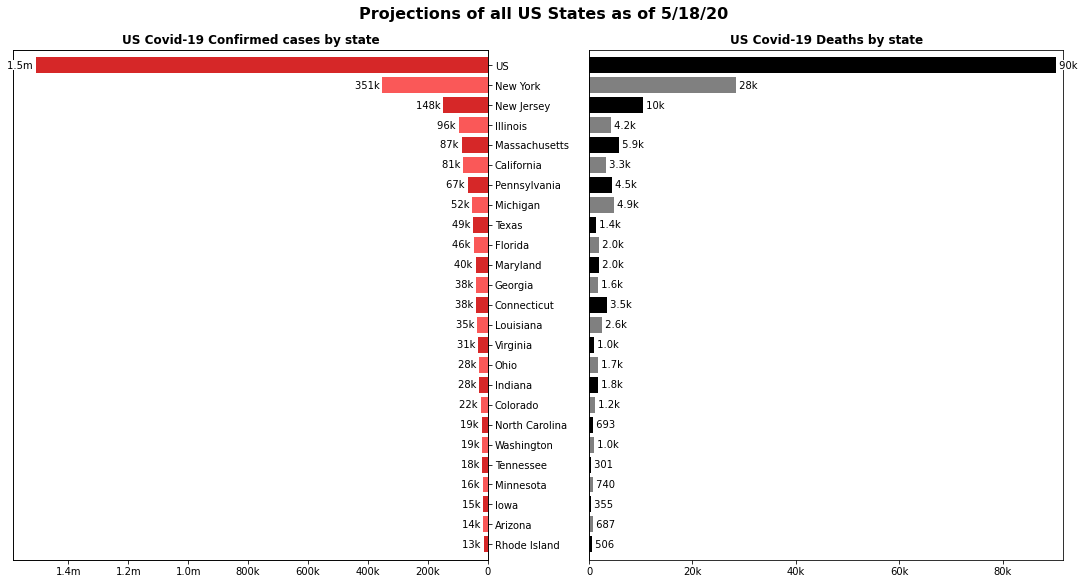

In [32]:
# Summary of US Stats with number of cases above the threshold
threshold=100
validCountries=[]
for name in confd.index.values:
    confv=confd.loc[name, confd.columns[-1]]
    if confv>=threshold:
        summary={
            'Name':        name,
            'Cases':       confv,
            'CaseGrowth':  confdDeltaPerc .loc[name, confd.columns[-1]],
            'Deaths':      deaths         .loc[name, confd.columns[-1]]
            #'DeathsGrowth':deathsDeltaPerc.loc[name, confd.columns[-1]]
            #'CrudeCFR':    crudeCFR       .loc[name, confd.columns[-1]]
        }
        validCountries.append(summary)

# Prepare sorted stats, and limit to top countries
validCountries.sort(key=lambda x: x['Cases'], reverse=True)
validCountriesForCharts=validCountries[:25]

# Prepare data for plots
countryNames=[x['Name'] for x in validCountriesForCharts]
countryCases=[x['Cases'] for x in validCountriesForCharts]
countryDeaths=[x['Deaths'] for x in validCountriesForCharts]


# All states plot
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=[15,8], constrained_layout=True)
fig.suptitle('Projections of all US States as of %s' % today, fontsize="16", fontweight='bold')
alternatingColorsCases=['tab:red','#fa5858']*int(len(countryNames)/2)
#alternatingColorsDeaths=['black','grey']*int(len(countryNames)/2)
alternatingColorsDeaths=['black','grey']*int(len(countryNames)/2)

# L Plot lastest confirmed cases by state
#ax[0].set_xscale('log')
ax[0].set_title('US Covid-19 Confirmed cases by state', fontweight='bold')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames, countryCases, color=alternatingColorsCases)
#ax2.set_xscale('log')
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%s " % FormatReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# R: Plot deaths by state
ax[1].set_title('US Covid-19 Deaths by state', fontweight='bold')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(hrFormatter)
ax[1].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[1].margins(0.015)
ax[1].barh(countryNames, countryDeaths, color=alternatingColorsDeaths)
#ax[1].set_xscale('log')
for i, v in enumerate(countryDeaths):
    if v!=0:
        ax[1].text(v, i, " %s " % FormatReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
        
plt.show()

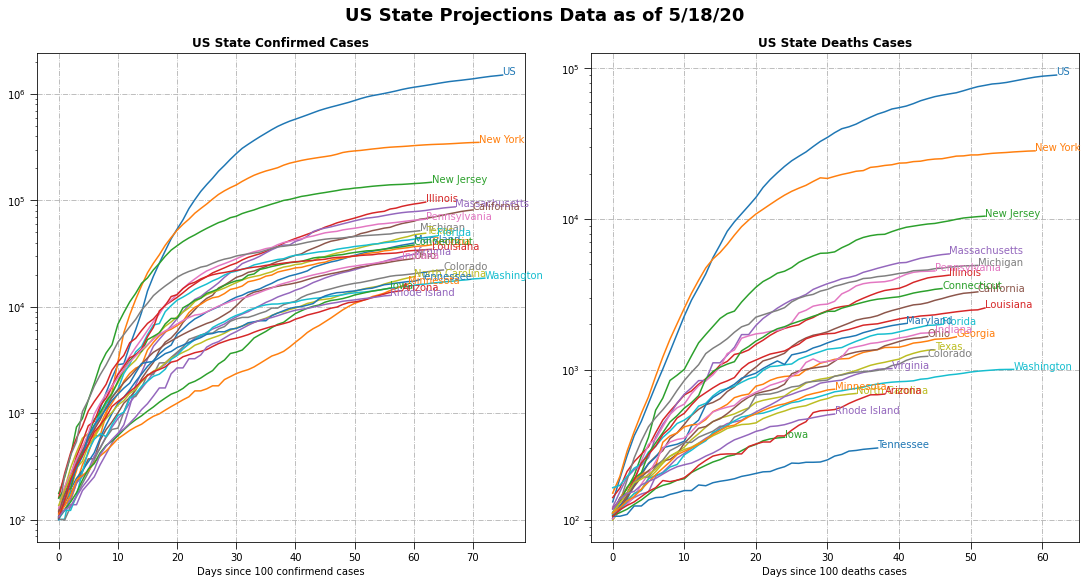

In [27]:
# State plots
#############################

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start, factor, length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.01f%% growth" % (factor*100-100), color=c) #changed from .1% to .01%

# Plot per country, setting y=0 where the country data set crosses the threshold
def plotState(ax, df, refDf, vstate, threshold, yscale, label, xlabel, ylabel, yformatter):
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xlabel(xlabel)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
        
    ax.set_yscale(yscale)
    ax.yaxis.set_major_formatter(yformatter)
    ax.tick_params(which='major', length=7)
    ax.set_yscale('log')
    ax.grid(True, linestyle='-.')
    # Plot individual country curves
    maxLen=0
    for i, cty in enumerate(vstate, start=0):
        name=cty['Name']
        days, daynr, values=getData(df, name)
        if (refDf is None):
            shiftedValues=startAtN(values, threshold)
        else:
            refDays, refDaynr, refValues=getData(refDf, name)
            shiftedRefValues=startAtN(refValues, threshold)
            shiftedValues=values[-len(shiftedRefValues):] if len(shiftedRefValues)>0 else []
        if(len(shiftedValues)>0):
            if(len(shiftedValues)>maxLen):
                maxLen=len(shiftedValues)
            line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
            c=line.get_color()
            ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)
    

threshold=100
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=[15,8], constrained_layout=True)
fig.suptitle('US State Projections Data as of %s' % today, fontsize="18", fontweight='bold')

plotState(ax[0], confd, None, validCountriesForCharts, threshold, 'log', 
                         "US State Confirmed Cases",
                         "Days since %s confirmend cases" % FormatReadable(threshold),
                         None, hrFormatter)

plotState(ax[1], deaths, None, validCountriesForCharts, threshold, 'log', 
                         "US State Deaths Cases",
                         "Days since %s deaths cases" % FormatReadable(threshold),
                         None, hrFormatter)

#plotState(ax[2], deaths/confd, deaths, validCountriesForCharts, threshold, 'linear', 
                       #  "Crude CFR",
                       #  "Days since country reached %s deaths" % FormatReadable(threshold),
                        # None, plticker.PercentFormatter(1.0))
if Path is None:
    Path = 'plotsUS/US_states_compare_confrm_{}.png'.format(confd)

    fig.savefig(Path, bbox_inches='tight')
    

plt.show()